# Can We Build It?

Building permits provide a valuable source of information on construction and housing development in San Francisco. By examining the record of building permits, we will identify key features of a projects that make permit approval faster and cheaper for property owners. In doing so, we hope to gain insight into a smaller, but important subgroup of building permits in San Francisco: the addition of units by owners of smaller properties. The SF municipality is suffering from a shortage of housing units, in part due to onerous regulatory and permit challenges. By clarifying aspects of the permitting process, we can provide owners the data they need to confidently increase the supply of housing in our city.

*Note*: Since this is historic data, it is likely that some properties have been counted multiple times, for different purposes, and totalling the units or permits does NOT equal the number of housing units in the city. Instead, a quick search indicates that SF has ~390k housing units total(from Census & city data), and some adjustment may be needed to uniquely identify permits where units were added. The following analysis instead examines the characteristics of all housing permit applications including geographic location, construction costs, and length of permit approval process.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# handles geodata
import geopandas as gp
# converts coordinate pairs into points that can be interpreted by geopandas
from shapely.geometry import Point
# map plotting
import geoplot as gplt
import geoplot.crs as gcrs
# geoplot is based on cartopy
import cartopy
import cartopy.crs as ccrs

In [3]:
# Convert the location information for geopandas
def parse_point(record):
    try:
        pieces = record.split() # splits each record into a list of 3
        x = float(pieces[0].lstrip('(').rstrip(',')) # latitude
        y = float(pieces[1].rstrip(')')) # longitude 
        point = Point(x,y) # convert to Shapely Point
    except:
        print(record)
    return point



In [4]:
df = pd.read_csv('Building_Permits.csv')
df['PID'] = df['Location'].dropna().map(lambda x: parse_point(x))
df.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID', 'SF Fi

In [5]:
# Quick check to see that the ID#s are unique
len(df['Record ID'].unique()) == len(df.index)

True

In [6]:
# Top 10  most popular reasons for permits
df['Description'].value_counts().head(10)


reroofing                    98979
street space                 57276
street space permit          17604
reroofing.                    7131
horizontal addition           6803
sidewalk repair               4527
street space permit only.     4523
install aluminum windows      4104
streetspace                   3950
reroof                        3862
Name: Description, dtype: int64

In [7]:
# Statuses of the permits in the dataset. Note the large number of expired permits. Perhaps there is more to dig into there?
df['Current Status'].value_counts()

complete       620026
issued         230482
expired        225790
cancelled       26690
filed           21279
withdrawn        7894
approved         1610
reinstated       1292
filing           1196
disapproved       584
suspend           472
revoked           232
plancheck          60
appeal             28
issuing            23
denied             10
inspection          5
incomplete          3
unknown             2
upheld              1
granted             1
Name: Current Status, dtype: int64

Text(0.5, 1.0, 'Breakdown of Permit Types')

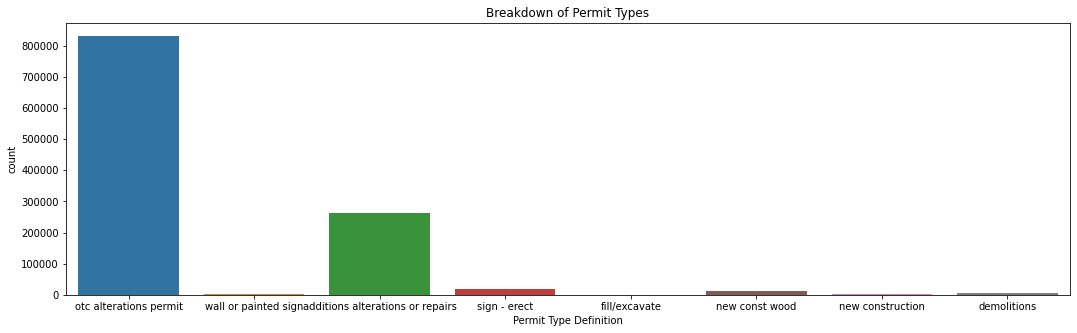

In [8]:
# Permit categories. Note: OTC permits are same-day permits for more minor projects
df['Permit Type Definition'].replace('grade or quarry or fill or excavate','fill/excavate', inplace=True)
df['Permit Type Definition'].replace('new construction wood frame','new const wood', inplace=True)
plt.figure(figsize=(18,5))
sns.countplot(df['Permit Type Definition'])
plt.title('Breakdown of Permit Types')

In [9]:
# Show neighborhood information
nb_df = df.groupby('Permit Type Definition').get_group('additions alterations or repairs').loc[:,['Current Status','Existing Units','Proposed Units','Estimated Cost', 'Revised Cost','Neighborhoods - Analysis Boundaries','PID']]
nb_df = nb_df.dropna().groupby(['Current Status']).get_group(('complete'))
nb_df['Units Added'] = (nb_df['Proposed Units'] - nb_df['Existing Units'])
nb_sums = nb_df.groupby(['Neighborhoods - Analysis Boundaries']).sum()

# Compare proposed to existing units to see how many have been included in a building permit
nb_sums['Units Added Pct'] = 100 * (nb_sums['Proposed Units'] - nb_sums['Existing Units'])/nb_sums['Existing Units']
nb_sums

,Existing Units,Proposed Units,Estimated Cost,Revised Cost,Units Added,Units Added Pct
Neighborhoods - Analysis Boundaries,,,,,,
Bayview Hunters Point,15427.0,15617.0,7.446502e+08,8.101556e+08,190.0,1.231607
Bernal Heights,3374.0,3398.0,2.981813e+08,3.127250e+08,24.0,0.711322
Castro/Upper Market,5394.0,5467.0,1.760215e+08,2.138790e+08,73.0,1.353356
Chinatown,34050.0,22193.0,2.808126e+08,3.279735e+08,-11857.0,-34.822320
Excelsior,1159.0,1294.0,3.570529e+07,5.160364e+07,135.0,11.647972
Financial District/South Beach,134454.0,137054.0,2.089523e+09,2.525455e+09,2600.0,1.933747
Glen Park,1674.0,1688.0,5.045746e+07,6.029435e+07,14.0,0.836320
Golden Gate Park,417.0,417.0,1.430713e+08,1.449263e+08,0.0,0.000000
Haight Ashbury,3875.0,3862.0,7.567901e+07,9.075011e+07,-13.0,-0.335484


There are a few neighborhoods(Chinatown, Inner Richmond) where a significant portion of units appear to be removed. Perhaps it would do to look into this further, but as noted above, the counts for 'Existing Units' reflect the total number of units referenced in all permits in each neighborhood, NOT the total units physically present in each neighborhood.

In [10]:
# Filter to only entries where the unit count changes
nb_unit_changes_only = nb_df[nb_df['Units Added'] != 0]
nb_unit_changes_only.groupby(['Neighborhoods - Analysis Boundaries']).sum().head()

,Existing Units,Proposed Units,Estimated Cost,Revised Cost,Units Added
Neighborhoods - Analysis Boundaries,,,,,
Bayview Hunters Point,420.0,610.0,31184956.0,41553236.00,190.0
Bernal Heights,176.0,200.0,4820807.0,6581703.99,24.0
Castro/Upper Market,477.0,550.0,15633706.0,21510889.00,73.0
Chinatown,12461.0,604.0,20901916.0,28893153.00,-11857.0
Excelsior,97.0,232.0,9265301.0,13637398.33,135.0


Examining the percentages above, it doesn't really appear that there were a lot of units added tracked in the permit information given here. This might make it difficult to conduct more advanced analysis on the variables affecting new unit construction, so perhaps more data is required, e.g widening the geographic range or getting additional information on the properties where additional units were added. 



Additional neighborhood analysis is conducted below.



## Examining the Number of Days Required for Permit Approval
Calculate the number of days for approval of permits not qualifying for 'OTC' or same day approval, excluding permit entries without valid date information


In [11]:
dates_df = df.groupby('Permit Type Definition').get_group('additions alterations or repairs').loc[:, 'Filed Date':'Issued Date'].dropna().apply(pd.to_datetime)
dates_df['Approval Time'] = dates_df['Issued Date'] - dates_df['Filed Date']
dates_df['Approval Time'] = dates_df['Approval Time'].apply(lambda x: x.days)


In [12]:
# The first date in the permits dataset
dates_df['Issued Date'].min()

Timestamp('1919-03-03 00:00:00')

In [13]:
# Looks like there are some entries that have errors in entering the approval dates. ~.2% seems okay to drop
dates_df['Approval Time'][dates_df['Approval Time']<0]

6966       -2
148280     -7
148291     -7
178869     -1
183727     -6
           ..
926772    -46
939455     -9
994915    -27
997210    -69
1006260    -6
Name: Approval Time, Length: 71, dtype: int64

In [14]:
# Drop negative values by excluding them from the interval (no)
approval_bins = pd.IntervalIndex.from_tuples([(-0.1,0),(0,30),(30,365),(365,700), (700,29608)],closed='right')
dates_df['Grouped Approval'] = pd.cut(dates_df['Approval Time'], approval_bins).dropna().astype('str')
dates_df['Grouped Approval'].replace({'(-0.1, 0.0]':'Same Day', '(0.0, 30.0]':'Same Month', '(30.0, 365.0]':'Same Year', '(365.0, 700.0]':'Next Year',
       '(700.0, 29608.0]':'2 Years+'}, inplace=True)

Text(0, 0.5, 'Number of Permits')

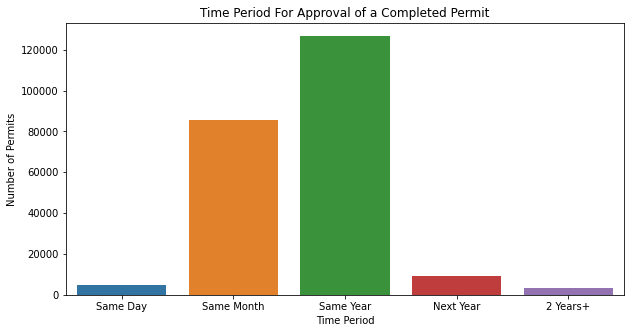

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(dates_df['Grouped Approval'].dropna(), order = ['Same Day', 'Same Month', 'Same Year', 'Next Year', '2 Years+'])
plt.title('Time Period For Approval of a Completed Permit')
plt.xlabel('Time Period')
plt.ylabel('Number of Permits')

In [16]:
dates_df['Approval Time'].max()
# find and drop wait times with negative values
# find and examine wait times >10000 days (see how many there are?)

29608

In [17]:
dates_df.iloc[np.where(dates_df['Approval Time'] == 29608)[0]]

,Filed Date,Issued Date,Approval Time,Grouped Approval
1082547,1901-03-10,1982-04-02,29608,2 Years+


In [18]:
# There are a few thousand entries with extremely long wait times (>2 years) for approval. Are these mostly larger developments?
len(dates_df['Approval Time'][(dates_df['Approval Time']>=700)])

3560

## Map of Completed Permits & More Neighborhood Considerations
Next, we'll show the projects completed in each neighborhood. We'll use the 'completed' 'additions...' type permits, as these are the permits proposing, and completing projects in each neighborhood.

In [19]:
# Create dataframe with the completed alterations/repairs
nb_df = df.groupby('Permit Type Definition').get_group('additions alterations or repairs').loc[:,['Current Status','Number of Existing Stories','Number of Proposed Stories','Existing Units','Proposed Units','Estimated Cost', 'Revised Cost','Neighborhoods - Analysis Boundaries','PID']]
nb_df = nb_df.dropna().groupby(['Current Status']).get_group(('complete'))
nb_df.rename(columns={'PID':'geometry'},inplace=True)
nb_df.columns

Index(['Current Status', 'Number of Existing Stories',
       'Number of Proposed Stories', 'Existing Units', 'Proposed Units',
       'Estimated Cost', 'Revised Cost', 'Neighborhoods - Analysis Boundaries',
       'geometry'],
      dtype='object')

In [20]:
#read in a shapefile
sfneigh = gp.read_file('Analysis Neighborhoods.geojson')
sfneigh.crs = {'init':'epsg:4326'}
sfneigh.rename(columns = {'nhood':'Neighborhood'}, inplace = True)
sfneigh.set_index('Neighborhood',inplace=True)


In [21]:
# Convert the neighborhood information to geopandas
nbgeo = gp.GeoDataFrame(nb_df, geometry='geometry')#.set_index('Neighborhoods - Analysis Boundaries')
nbgeo.crs = {'init':gcrs.LambertConformal()}
nbgeo['Units Added'] = nbgeo['Proposed Units'] - nbgeo['Existing Units']
nbgeo.head()

,Current Status,Number of Existing Stories,Number of Proposed Stories,Existing Units,Proposed Units,Estimated Cost,Revised Cost,Neighborhoods - Analysis Boundaries,geometry,Units Added
1680,complete,6.0,6.0,0.0,0.0,3800000.0,3800000.0,Financial District/South Beach,POINT (37.787 -122.403),0.0
4056,complete,5.0,5.0,1.0,1.0,15000.0,15000.0,Noe Valley,POINT (37.744 -122.435),0.0
4069,complete,9.0,9.0,0.0,0.0,10000.0,10000.0,Financial District/South Beach,POINT (37.789 -122.403),0.0
4079,complete,3.0,3.0,1.0,1.0,4890.0,25000.0,Bayview Hunters Point,POINT (37.730 -122.372),0.0
4122,complete,2.0,2.0,1.0,1.0,80000.0,80000.0,Inner Sunset,POINT (37.756 -122.471),0.0


In [22]:
nb_perms = nbgeo['Neighborhoods - Analysis Boundaries'].value_counts().to_frame()
nb_perms_by_neigh = gp.GeoDataFrame(nb_perms.merge(sfneigh.geometry.to_frame(), left_index = True, right_index = True))
nb_perms_by_neigh.rename(columns={'Neighborhoods - Analysis Boundaries':'permits'},inplace=True)
nb_perms_by_neigh.head()

,permits,geometry
Financial District/South Beach,10318,"MULTIPOLYGON (((-122.38753 37.78280, -122.3875..."
Mission,2858,"MULTIPOLYGON (((-122.41096 37.76943, -122.4109..."
South of Market,2299,"MULTIPOLYGON (((-122.40371 37.78404, -122.4027..."
Sunset/Parkside,2275,"MULTIPOLYGON (((-122.47731 37.76545, -122.4772..."
Bayview Hunters Point,2011,"MULTIPOLYGON (((-122.38158 37.75307, -122.3815..."


Text(0.5, 1.0, 'Completed Permits by Neighborhood')

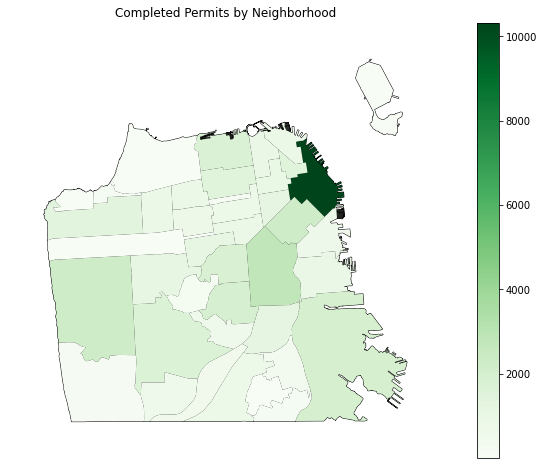

In [23]:
ax = gplt.polyplot(sfneigh, projection = gcrs.LambertConformal(), figsize=(12,8), edgecolor="k")
gplt.choropleth(nb_perms_by_neigh, projection=gcrs.LambertConformal(), hue='permits',ax=ax, cmap="Greens",legend=True)
plt.title('Completed Permits by Neighborhood')

## Project Costs
In addition to the locations of construction projects, the costs referenced in an application are important to a property owner in that the fee for filing a permit is based on the cost of the project. Being able to identify factors that will increase the price of a project will also help owners make decisions about the utility of the options available.

Text(0.5, 1.0, 'Revised Cost Distribution')

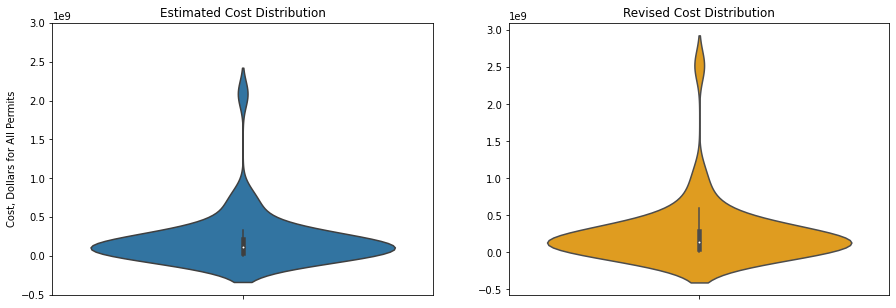

In [24]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
plt.ylabel('Cost, Dollars for All Permits')
ax.set_ylim(-0.5 * 10**9, 3.0 * 10**9)
sns.violinplot(y=nb_sums['Estimated Cost'].to_frame())
plt.title('Estimated Cost Distribution')

plt.subplot(1,2,2)
sns.violinplot(y=nb_sums['Revised Cost'].to_frame(), color='orange')
plt.title('Revised Cost Distribution')

In [25]:
# Could improve formatting of table (PrettyPrint?)
for i1,i2,i3 in zip(nb_sums["Estimated Cost"].describe().index,nb_sums["Estimated Cost"].describe(),nb_sums["Revised Cost"].describe()):
    print(f'{i1}:\t{i2}\t{i3}')

count:	41.0	41.0
mean:	214810044.7012195	261473480.48195124
std:	351982743.0532875	426258059.5775854
min:	95000.0	204000.0
25%:	35705291.0	51603639.150000006
50%:	111441967.28000002	139828199.85
75%:	218514942.0	291674242.78999996
max:	2089523494.6799998	2525454694.4399996


It appears that the the average revised cost for a permit is higher than the estimated. Perhaps there is some insight to draw here about what might indicate that a project will be significantly more expensive than an initial estimate. There is also an indication that some projects have negative costs. **Some data munging will be required to either fix, or eliminate these projects from consideration.**

## WIP
The following is an exploration of the units added in each neighborhood. While the permit completions on the figure above seem reasonable, there appear to be a net loss of units in several neighborhoods, even though the overall housing stock in the city has grown modestly in the past few years (~9% in the last decade). Perhaps this is due to the timespan of the dataset, and examining a narrower time interval will show more relevant results.

In [26]:
# nb_units_by_neigh = nbgeo.groupby('Neighborhoods - Analysis Boundaries')['Proposed Units'].sum()
nb_units_by_neigh = gp.GeoDataFrame(nbgeo.groupby('Neighborhoods - Analysis Boundaries')['Units Added'].sum().to_frame().merge(sfneigh.geometry.to_frame(), left_index = True, right_index = True))

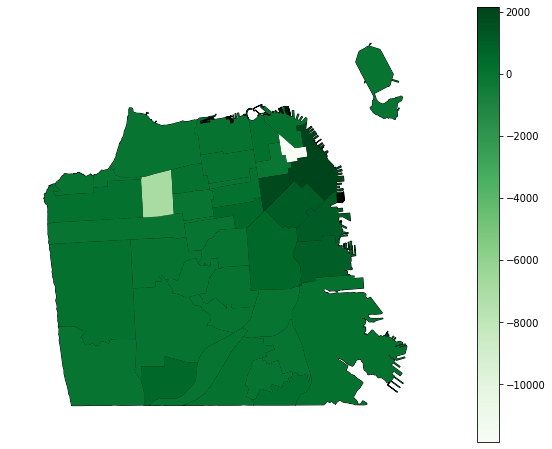

In [27]:
ax = gplt.polyplot(sfneigh, projection = gcrs.LambertConformal(), figsize=(12,8), edgecolor="k")
gplt.choropleth(nb_units_by_neigh, hue='Units Added', ax=ax, cmap='Greens', legend=True) #works fine
